Libraries

In [1]:
from IPython import display
import numpy as np
from matplotlib import pyplot as plt
import progressbar

import torch
from torch import nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision.utils as vutils
from torchvision import transforms, datasets

Hyperparameters

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

OUTPUT_DIR = './data/CIFAR-10'
BATCH_SIZE = 100
LR = 0.0002
NUM_EPOCHS = 5
NUM_TEST_SAMPLES = 32

# Define the generator and discriminator architectures and other necessary functions as before...

# Initialize lists to store losses
d_losses = []
g_losses = []

In [3]:
def load_data():
    compose = transforms.Compose(
        [
            transforms.Resize(64),
            transforms.ToTensor(),
            transforms.Normalize((.5, .5, .5), (.5, .5, .5))
        ])
    return datasets.CIFAR10(root=OUTPUT_DIR, train=True, transform=compose, download=True)

data = load_data()
# data = torch.utils.data.Subset(data, [0, 5000])
data_loader = torch.utils.data.DataLoader(data, batch_size=BATCH_SIZE, shuffle=True)
NUM_BATCHES = len(data_loader)

print("No. of Batches = ", NUM_BATCHES)

100%|██████████| 170498071/170498071 [00:04<00:00, 41941091.99it/s]


Extracting ./data/CIFAR-10/cifar-10-python.tar.gz to ./data/CIFAR-10
No. of Batches =  500


Discriminator

In [4]:
class Discriminator(torch.nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()

        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False), nn.LeakyReLU(0.2, inplace=True))
        self.conv2 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False), nn.BatchNorm2d(256), nn.LeakyReLU(0.2, inplace=True))
        self.conv3 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False), nn.BatchNorm2d(512), nn.LeakyReLU(0.2, inplace=True))
        self.conv4 = nn.Sequential(nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=4, stride=2, padding=1, bias=False), nn.BatchNorm2d(1024), nn.LeakyReLU(0.2, inplace=True))
        self.output = nn.Sequential(nn.Linear(1024*4*4, 1), nn.Sigmoid())

    def forward(self, x):
        # Convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        # Flatten and apply sigmoid
        x = x.view(-1, 1024*4*4)
        x = self.output(x)
        return x

Generator

In [5]:
class Generator(torch.nn.Module):

    def __init__(self):
        super(Generator, self).__init__()

        self.linear = torch.nn.Linear(100, 1024*4*4)
        self.deconv1 = nn.Sequential(nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False), nn.BatchNorm2d(512), nn.ReLU(inplace=True))
        self.deconv2 = nn.Sequential(nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False), nn.BatchNorm2d(256), nn.ReLU(inplace=True))
        self.deconv3 = nn.Sequential(nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False), nn.BatchNorm2d(128), nn.ReLU(inplace=True))
        self.deconv4 = nn.Sequential(nn.ConvTranspose2d(in_channels=128, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False))
        self.output = torch.nn.Tanh()

    def forward(self, x):
        # Project and reshape
        x = self.linear(x)
        x = x.view(x.shape[0], 1024, 4, 4)

        # Convolutional layers
        x = self.deconv1(x)
        x = self.deconv2(x)
        x = self.deconv3(x)
        x = self.deconv4(x)

        # Apply Tanh
        return self.output(x)

Generating Artificial Noise

In [6]:
def noise(size):
    n = Variable(torch.randn(size, 100))
    if torch.cuda.is_available():
      return n.cuda()
    return n

In [7]:
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('BatchNorm') != -1:
        m.weight.data.normal_(0.00, 0.02)

In [8]:
generator = Generator()
discriminator = Discriminator()
generator.apply(init_weights)
discriminator.apply(init_weights)

# Enable cuda if available
if torch.cuda.is_available():
    generator.cuda()
    discriminator.cuda()

Defining optimizers for Generator and Discriminator nets.

In [9]:
# d_optimizer = optim.SGD(discriminator.parameters(), lr=LR, momentum=0.9)
# g_optimizer = optim.SGD(generator.parameters(), lr=LR, momentum=0.9)
d_optimizer = optim.Adam(discriminator.parameters(), lr=LR, betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=LR, betas=(0.5, 0.999))

# Loss function
# criterion = nn.MSELoss()
criterion = nn.BCELoss()

## Use Adam Optimizer with BCELoss function


In [10]:
def real_data_target(size):
    data = Variable(torch.ones(size, 1))
    if torch.cuda.is_available():
      return data.cuda()
    return data

def fake_data_target(size):
    data = Variable(torch.zeros(size, 1))
    if torch.cuda.is_available():
      return data.cuda()
    return data

In [11]:
def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()

    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = criterion(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = criterion(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()

    # 1.3 Update weights with gradients
    optimizer.step()

    # Return error
    return error_real + error_fake, prediction_real, prediction_fake

def train_generator(optimizer, fake_data):
    # 2. Train Generator
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = criterion(prediction, real_data_target(prediction.size(0)))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

In [12]:
test_noise = noise(NUM_TEST_SAMPLES)

In [13]:
def generate_images(test_images, num_images, normalize=True):
  images = test_images

  # Make horizontal grid from image tensor
  horizontal_grid = vutils.make_grid(images, normalize=normalize, scale_each=True)
  # Make vertical grid from image tensor
  nrows = int(np.sqrt(num_images))
  grid = vutils.make_grid(images, nrow=nrows, normalize=True, scale_each=True)

  # Plot and save horizontal
  fig = plt.figure(figsize=(16, 16))
  plt.imshow(np.moveaxis(horizontal_grid.numpy(), 0, -1))
  plt.axis('off')
  if True:
    display.display(plt.gcf())
  plt.close()

  # Save squared
  fig = plt.figure()
  plt.imshow(np.moveaxis(grid.numpy(), 0, -1))
  plt.axis('off')
  plt.close()

Training

  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


Epoch # 0 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:04:16 Time:  0:04:16


Loss (Discriminator): 0.6539302860945463
Loss (Generator): 3.0245500235259533


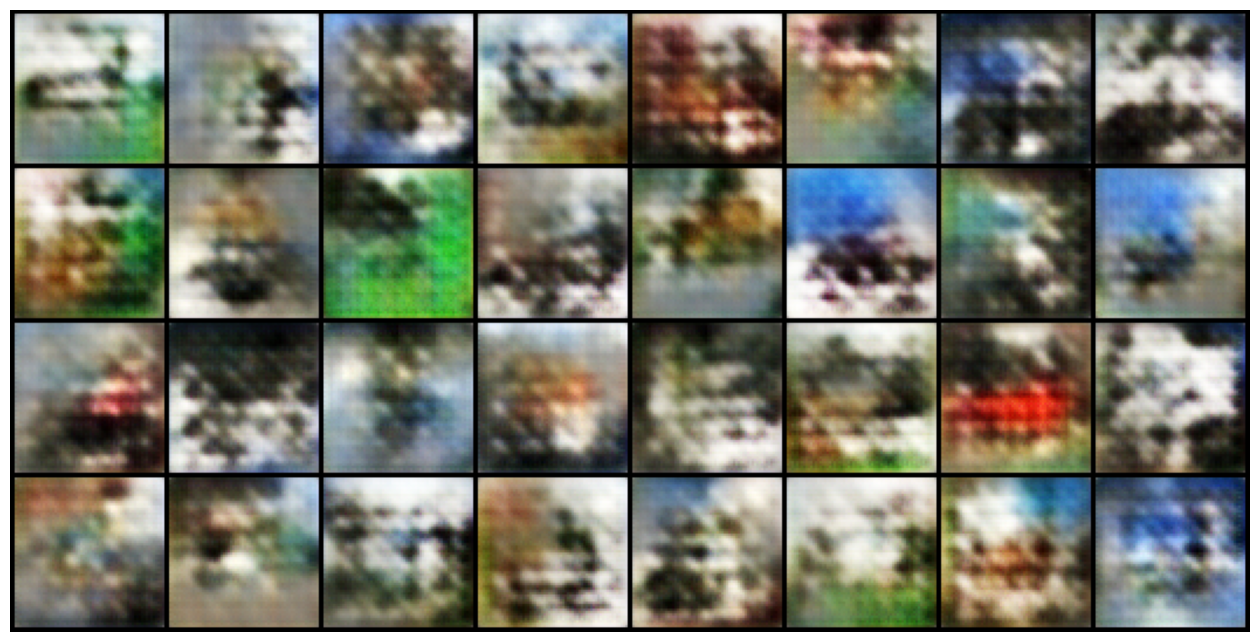

  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


Epoch # 1 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:04:18 Time:  0:04:18


Loss (Discriminator): 0.953337642788887
Loss (Generator): 2.0303916257172823


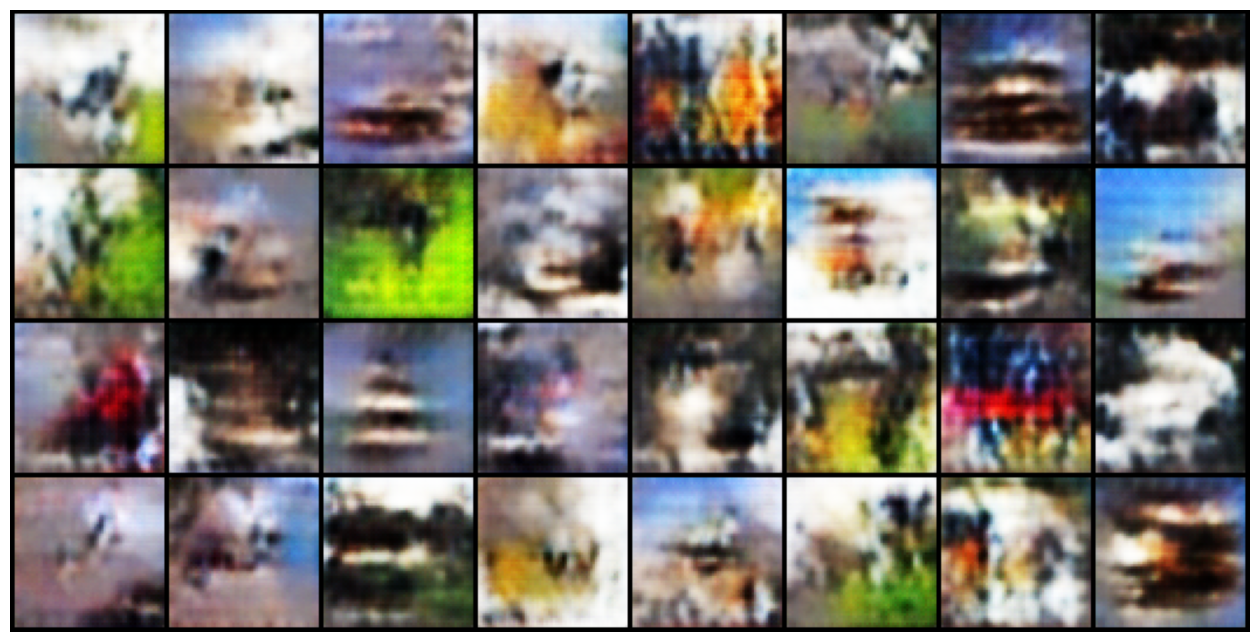

  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


Epoch # 2 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:04:16 Time:  0:04:16


Loss (Discriminator): 0.9890046873092652
Loss (Generator): 1.8173223440051078


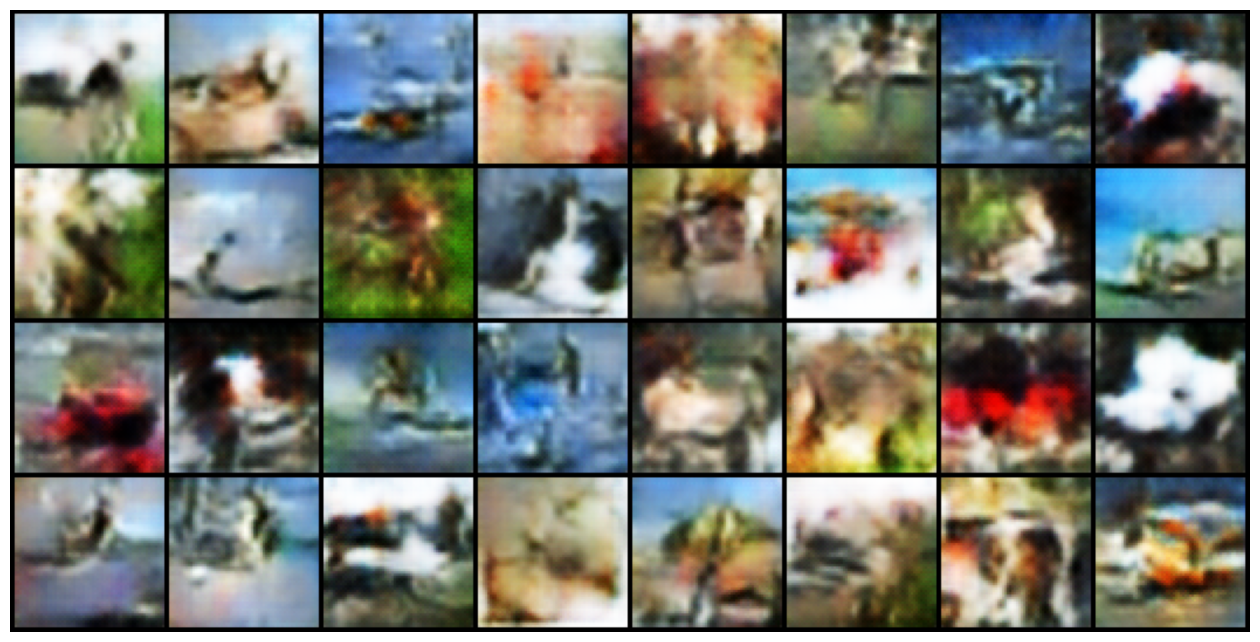

  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


Epoch # 3 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:04:17 Time:  0:04:17


Loss (Discriminator): 0.92192097312212
Loss (Generator): 1.9134679102301597


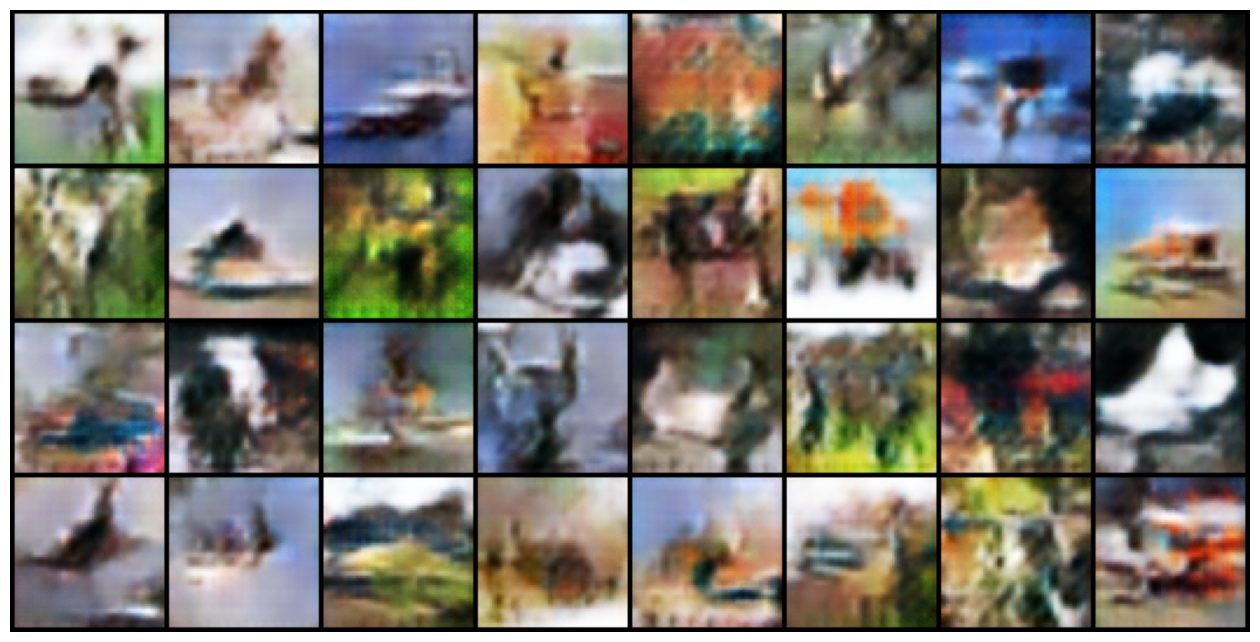

  0% (0 of 500) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


Epoch # 4 in progress...


100% (500 of 500) |######################| Elapsed Time: 0:04:17 Time:  0:04:17


Loss (Discriminator): 0.8473818144798279
Loss (Generator): 2.080211534231901


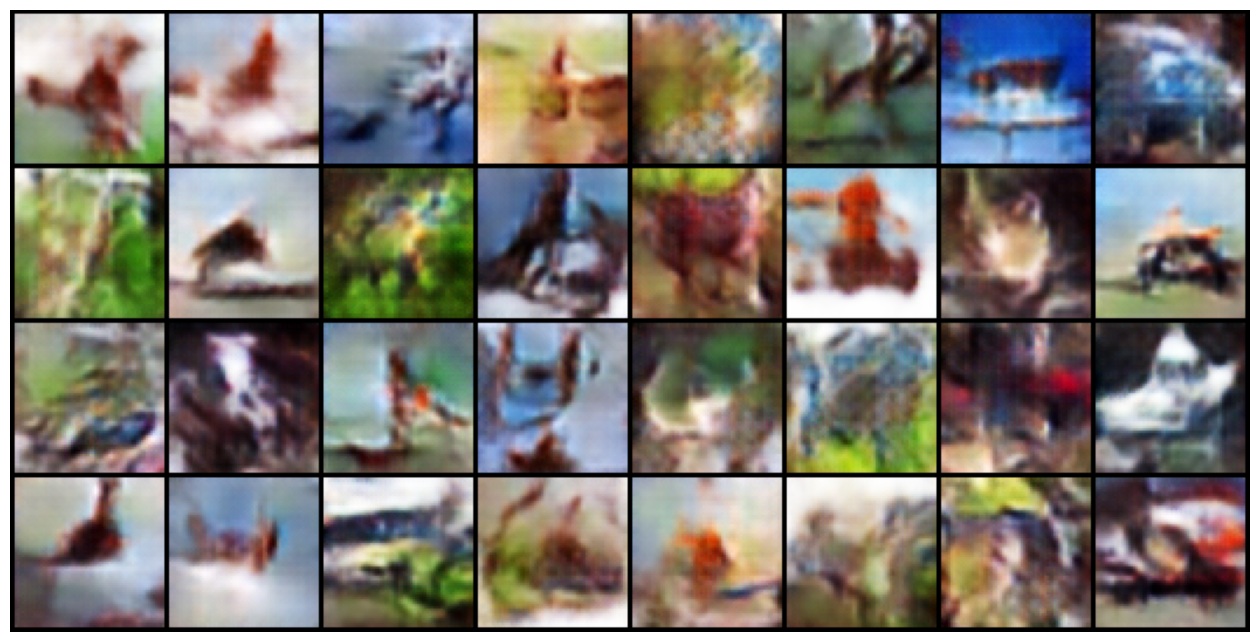

In [14]:
d_losses = []
g_losses = []

for epoch in range(5):
    print("\nEpoch #", epoch, "in progress...")
    progress_bar = progressbar.ProgressBar()
    d_running_loss = 0
    g_running_loss = 0

    for n_batch, (real_batch, _) in enumerate(progress_bar(data_loader)):
        real_data = Variable(real_batch)
        if torch.cuda.is_available():
            real_data = real_data.cuda()

        # Train Discriminator
        fake_data = generator(noise(real_data.size(0))).detach()
        d_error, _, _ = train_discriminator(d_optimizer, real_data, fake_data)

        # Train Generator
        fake_data = generator(noise(real_batch.size(0)))
        g_error = train_generator(g_optimizer, fake_data)

        d_running_loss += d_error.item()
        g_running_loss += g_error.item()

    # Append epoch losses to lists
    d_losses.append(d_running_loss / NUM_BATCHES)
    g_losses.append(g_running_loss / NUM_BATCHES)

    print("Loss (Discriminator):", d_losses[-1])
    print("Loss (Generator):", g_losses[-1])

    test_images = generator(test_noise).data.cpu()
    generate_images(test_images, NUM_TEST_SAMPLES)



In [16]:
# prompt: print both list values

print("Discriminator losses:", d_losses)
print("Generator losses:", g_losses)


Discriminator losses: [0.6539302860945463, 0.953337642788887, 0.9890046873092652, 0.92192097312212, 0.8473818144798279]
Generator losses: [3.0245500235259533, 2.0303916257172823, 1.8173223440051078, 1.9134679102301597, 2.080211534231901]


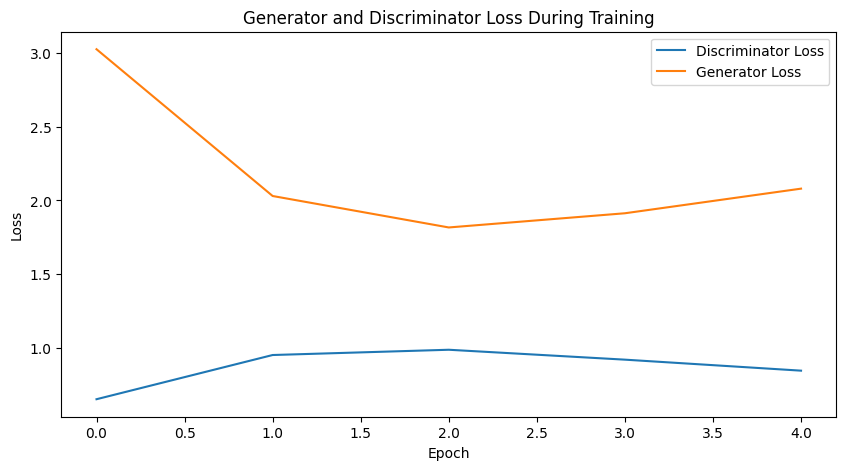

In [17]:
# prompt: plot list values over epochs for generattor loss and discriminator loss

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(d_losses, label="Discriminator Loss")
plt.plot(g_losses, label="Generator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [27]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from pytorch_fid import fid_score

# Load the InceptionV3 model
inception_model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)
inception_model.eval()

from PIL import Image

def calculate_activations(images, model):
    # Preprocess images
    preprocess = transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.ToTensor(),  # Convert PIL Image to tensor
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])
    # Calculate activations
    activations = []
    for img in images:
        with torch.no_grad():
            # Convert image tensor to PIL Image
            img_pil = transforms.ToPILImage()(img.cpu())
            img_pil = img_pil.convert("RGB")
            img_tensor = preprocess(img_pil).unsqueeze(0)
            activations.append(model(img_tensor).detach().squeeze())
    return torch.stack(activations)

def torch_cov(m, rowvar=False):
    if rowvar:
        m = m.T
    factor = 1.0 / (m.shape[1] - 1)
    m -= torch.mean(m, axis=1, keepdims=True)
    mt = m.t()
    return factor * m.matmul(mt).squeeze()

# Load real and generated images
real_images = [data_loader.dataset[i][0] for i in range(NUM_TEST_SAMPLES)]
generated_images = generator(test_noise).data.cpu()

# Calculate activations
real_activations = calculate_activations(real_images, inception_model)
generated_activations = calculate_activations(generated_images, inception_model)

# Calculate mean and covariance for real and generated activations
mu1, sigma1 = real_activations.mean(dim=0), torch_cov(real_activations, rowvar=False)
mu2, sigma2 = generated_activations.mean(dim=0), torch_cov(generated_activations, rowvar=False)

# Calculate FID score
fid_score_value = fid_score.calculate_frechet_distance(mu1.numpy(), sigma1.numpy(), mu2.numpy(), sigma2.numpy())
print("FID Score:", fid_score_value)



Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


FID Score: 220.1793212890625


In [21]:
from pytorch_fid import fid_score

import pytorch_fid

print(dir(pytorch_fid.fid_score))


['ArgumentDefaultsHelpFormatter', 'ArgumentParser', 'IMAGE_EXTENSIONS', 'Image', 'ImagePathDataset', 'InceptionV3', 'TF', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'adaptive_avg_pool2d', 'calculate_activation_statistics', 'calculate_fid_given_paths', 'calculate_frechet_distance', 'compute_statistics_of_path', 'get_activations', 'linalg', 'main', 'np', 'os', 'parser', 'pathlib', 'save_fid_stats', 'torch', 'tqdm']


Testing

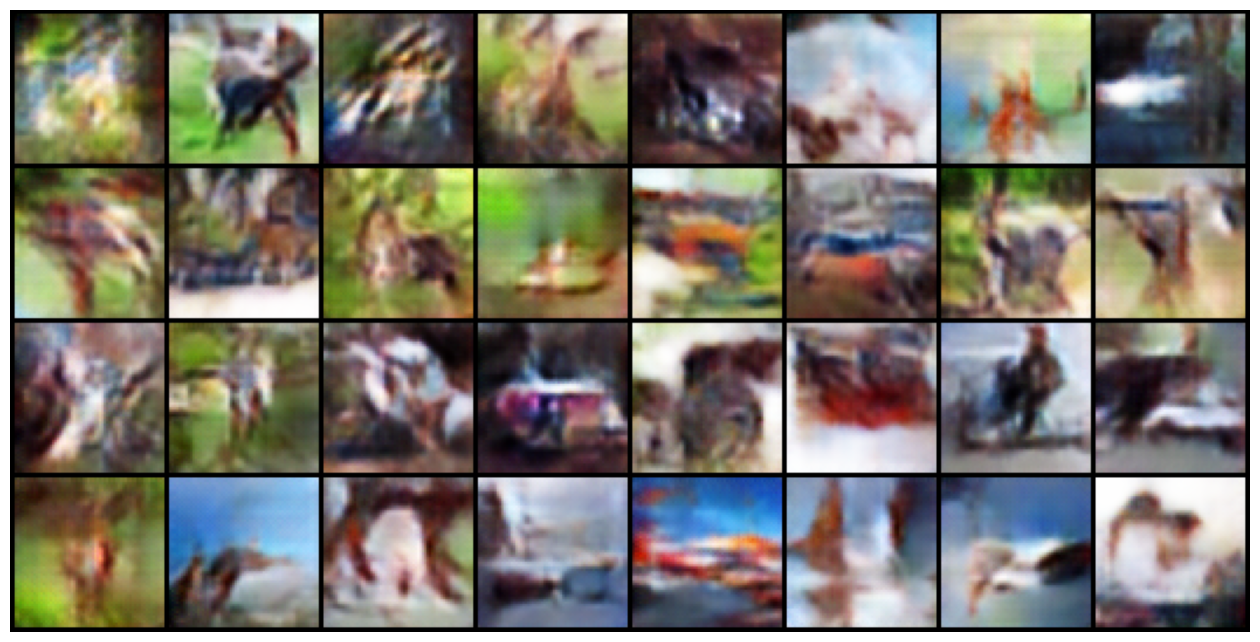

In [15]:
num_samples = NUM_TEST_SAMPLES
test_noise = noise(num_samples)
test_images = generator(test_noise).data.cpu()
generate_images(test_images, NUM_TEST_SAMPLES)

Hyperparameter tuning

In [ ]:
# perform hyperparameter tuning through loop
# define a list of hyperparameters
# loop through the list of hyperparameters
# train the model   

# define a list of hyperparameters
hyperparameters = {
    'lr': [0.0001, 0.0002, 0.0003],
    'batch_size': [50, 100, 150],
    'num_epochs': [5, 10, 15]
}

# loop through the list of hyperparameters
for lr in hyperparameters['lr']:
    for batch_size in hyperparameters['batch_size']:
        for num_epochs in hyperparameters['num_epochs']:
            print("Training with hyperparameters: lr={}, batch_size={}, num_epochs={}".format(lr, batch_size, num_epochs))
            # train the model
            # define the generator and discriminator
            generator = Generator()
            discriminator = Discriminator()
            generator.apply(init_weights)
            discriminator.apply(init_weights)

            # Enable cuda if available
            if torch.cuda.is_available():
                generator.cuda()
                discriminator.cuda()

            # d_optimizer = optim.SGD(discriminator.parameters(), lr=LR, momentum=0.9)
            # g_optimizer = optim.SGD(generator.parameters(), lr=LR, momentum=0.9)
            d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
            g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

            # Loss function
            # criterion = nn.MSELoss()
            criterion = nn.BCELoss()

            d_losses = []
            g_losses = []

            for epoch in range(num_epochs):
                print("\nEpoch #", epoch, "in progress...")
                progress_bar = progressbar.ProgressBar()
                d_running_loss = 0
                g_running_loss = 0

                for n_batch, (real_batch, _) in enumerate(progress_bar(data_loader)):
                    real_data = Variable(real_batch)
                    if torch.cuda.is_available():
                        real_data = real_data.cuda()

                    # Train Discriminator
                    fake_data = generator(noise(real_data.size(0))).detach()
                    d_error, _, _ = train_discriminator(d_optimizer, real_data, fake_data)

                    # Train Generator
                    fake_data = generator(noise(real_batch.size(0)))
                    g_error = train_generator(g_optimizer, fake_data)

                    d_running_loss += d_error.item()
                    g_running_loss += g_error.item()

                # Append epoch losses to lists
                d_losses.append(d_running_loss / NUM_BATCHES)
                g_losses.append(g_running_loss / NUM_BATCHES)

                print("Loss (Discriminator):", d_losses[-1])
                print("Loss (Generator):", g_losses[-1])

                test_images = generator(test_noise).data.cpu()
                generate_images(test_images, NUM_TEST_SAMPLES)

            print("Discriminator losses:", d_losses)
            print("Generator losses:", g_losses)    

            plt.figure(figsize=(10, 5))
            plt.title("Generator and Discriminator Loss During Training")
            plt.plot(d_losses, label="Discriminator Loss")  
            plt.plot(g_losses, label="Generator Loss")
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.legend()
            plt.show()

                    